# 资讯分析师

## 准备工作

pip安装 `akshare` 和 `langchain` 等必需的库：

In [1]:
%pip install --upgrade --quiet pandas akshare lark langchain-core langchain-openai langchain-community langchain-chroma langgraph

Note: you may need to restart the kernel to use updated packages.


获取股票主营介绍数据：

In [ ]:
import pandas as pd
import akshare as ak

# 沪深京 A 股实时行情数据
stock_zh_a_spot_em_df = ak.stock_zh_a_spot_em()
# 股票对应的主营介绍数据
stock_zyjs_ths_dfs = []
for stock_code, stock_name in zip(stock_zh_a_spot_em_df['代码'], stock_zh_a_spot_em_df['名称']):
    try:
        stock_zyjs_ths_df = ak.stock_zyjs_ths(stock_code)
        stock_zyjs_ths_df['股票名称'] = stock_name
        stock_zyjs_ths_dfs.append(stock_zyjs_ths_df)
    except Exception as e:
        print(f'Error processing stock {stock_code}: {e}')
        continue
stock_zyjs_ths_df = pd.concat(stock_zyjs_ths_dfs)
stock_zyjs_ths_df.to_csv('data/stock_zyjs_ths.csv', index=False, quoting=1)

加载股票主营介绍数据：

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    file_path='data/stock_zyjs_ths.csv',
    csv_args={
        'delimiter': ',',
        'quotechar': '"',
    },
    metadata_columns=['股票代码', '股票名称']
)

documents = loader.load()
print(f'Loaded {len(documents)} documents')

Loaded 5662 documents


embedding股票主营介绍数据并存储到向量数据库：

In [ ]:
import os
import pandas as pd

from langchain_openai import AzureOpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

ids = pd.read_csv('data/stock_zyjs_ths.csv')['股票代码'].astype(str).tolist()

for i in range(0, len(ids), 100):
    print(f'Adding documents {i} to {i+100}')
    partial_ids = ids[i:i+100]
    partial_documents = documents[i:i+100]
    # vector_store.add_documents(documents=partial_documents, ids=partial_ids)
    vector_store.update_documents(documents=partial_documents, ids=partial_ids)

## 资讯分析

初始化LLM模型和向量数据库：

In [11]:
import os

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_chroma import Chroma

llm = AzureChatOpenAI(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_CHAT_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_CHAT_API_VERSION'],
)

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

定义状态：

In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    news: str
    messages: Annotated[list, add_messages]
    report: str

定义获取财经新闻工具：

In [ ]:
import akshare as ak

def get_financial_news(state: State):
    """Call the AkShare API to get the latest financial news."""
    stock_info_global_sina_df = ak.stock_info_global_sina()
    first_stock_info = stock_info_global_sina_df.iloc[0]['内容']
    return {
        'news': first_stock_info
    }


定义大模型调用节点：

In [23]:
def call_llm(state: State):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

定义新闻分类节点:

In [30]:
from langchain_core.prompts import PromptTemplate

news_category_prompt_template = PromptTemplate.from_template('''你是一个财经新闻分类助手。请根据以下财经新闻的内容，将其分类到适当的类别中。可用的类别包括：
1. 公司财报
2. 并购与收购
3. 行业动态
4. 政策法规
5. 市场趋势
6. 投资策略
7. 经济指标
如果无法确定分类，请输出“无法确定”。
以下是需要分类的财经新闻：
{news}
''')

def get_news_category_prompt(state: State):
    prompt = news_category_prompt_template.invoke(state)
    return {
        'messages': prompt.to_messages()
    }

定义检索器节点：

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name='股票代码',
        description='股票代码',
        type='string',
    ),
    AttributeInfo(
        name='股票名称',
        description='股票名称',
        type='integer',
    ),
]

document_content_description = '股票主营介绍'

retriever = SelfQueryRetriever.from_llm(
    llm,
    vector_store,
    document_content_description,
    metadata_field_info,
)


定义输出报告节点：

In [43]:
def get_report(state: State):
    news = state['news']
    messages = state['messages']
    report = f'最新财经新闻：{news}\n分类结果：{messages[-1].content}'
    return {
        'report': report
    }

定义并编译图：

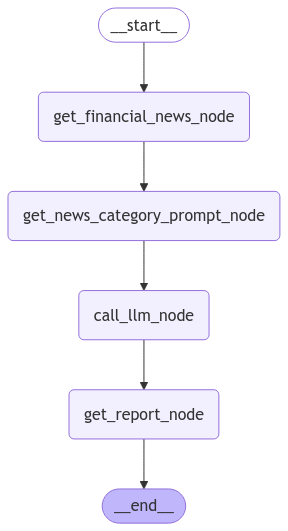

In [ ]:
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display

set_llm_cache(InMemoryCache())

workflow = StateGraph(State)
workflow.add_node('get_financial_news_node', get_financial_news)
workflow.add_node('get_news_category_prompt_node', get_news_category_prompt)
workflow.add_node('call_llm_node', call_llm)
workflow.add_node('get_report_node', get_report)

workflow.add_edge(START, 'get_financial_news_node')
workflow.add_edge('get_financial_news_node', 'get_news_category_prompt_node')
workflow.add_edge('get_news_category_prompt_node', 'call_llm_node')
workflow.add_edge('call_llm_node', 'get_report_node')
workflow.add_edge('get_report_node', END)

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

display(Image(app.get_graph().draw_mermaid_png()))


执行图：

In [45]:
final_state = app.invoke(
    {'news': None, 'messages': [], 'report': None},
    config={'configurable': {'thread_id': 'information_analysis'}},
)

print(final_state['report'])

最新财经新闻：法国外交部发言人：黎巴嫩新任总统为黎巴嫩开启新篇章，带来希望。呼吁所有黎巴嫩政治领导人和当局致力于国家的复苏，选举结果之后必须紧接着组建一个强有力的政府。新政府必须实施必要的改革，以促进黎巴嫩的经济复苏、稳定、安全和主权。
分类结果：无法确定
